In [15]:
# required libraries

import os
import re
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Loading data

In [ ]:
!gdown 1gJSVqBvTpEykMCCzK17GDv0WPtWBRWw4
!gdown 1N1kq2MdH_fwK_Byac_GSe1jaBuKnJCuK
!unzip PredictedMasks

## Preparing data

In [4]:
image_dir = Path('/content/PredictedMasks/PredictedMasks')
image_path = list(image_dir.glob(r'**/*.png'))
image_path.sort()
image_str_path = pd.Series(image_path, name='ImagePath').astype(str)
image_name = pd.Series([i.split("/")[-1] for i in image_str_path], name='ImageName')
data = pd.concat([image_str_path,image_name], axis=1)
data.head()

,ImagePath,ImageName
0,/content/PredictedMasks/PredictedMasks/000_HC.png,000_HC.png
1,/content/PredictedMasks/PredictedMasks/001_HC.png,001_HC.png
2,/content/PredictedMasks/PredictedMasks/002_HC.png,002_HC.png
3,/content/PredictedMasks/PredictedMasks/003_HC.png,003_HC.png
4,/content/PredictedMasks/PredictedMasks/004_HC.png,004_HC.png


In [5]:
# csv file
circumference = pd.read_csv('/content/training_set_pixel_size_and_HC.csv')
circumference.head()

,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


In [6]:
circumference = circumference.rename(columns={'filename': 'ImageName'})
circumference = circumference.drop(['pixel size(mm)'], axis=1)
circumference.head()

,ImageName,head circumference (mm)
0,000_HC.png,44.30
1,001_HC.png,56.81
2,002_HC.png,68.75
3,003_HC.png,69.00
4,004_HC.png,59.81


In [7]:
data = data.merge(circumference, on='ImageName')
data.head()

,ImagePath,ImageName,head circumference (mm)
0,/content/PredictedMasks/PredictedMasks/000_HC.png,000_HC.png,44.30
1,/content/PredictedMasks/PredictedMasks/001_HC.png,001_HC.png,56.81
2,/content/PredictedMasks/PredictedMasks/002_HC.png,002_HC.png,68.75
3,/content/PredictedMasks/PredictedMasks/003_HC.png,003_HC.png,69.00
4,/content/PredictedMasks/PredictedMasks/004_HC.png,004_HC.png,59.81


## Display the predicted masks and their circumference

In [8]:
def load_images(input):
  output = Image.open(input)
  output = output.resize((256,256))
  output = np.expand_dims(output, axis=0)
  return output

In [9]:
X = np.array([load_images(i) for i in data['ImagePath']]).reshape(999,256,256)/255
y = data['head circumference (mm)'].values

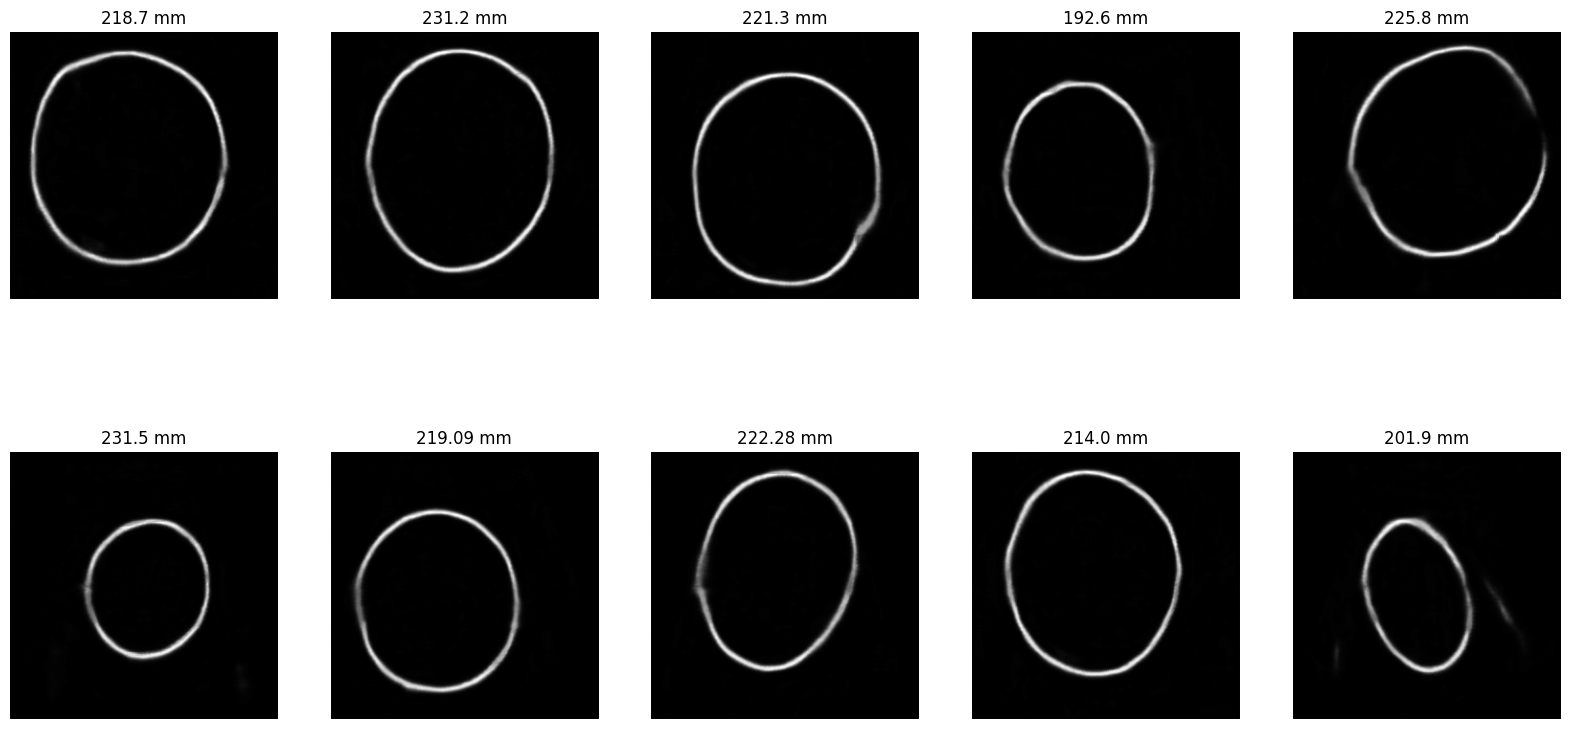

In [10]:
def display(ax, pic, label):
    ax.set_title(f'{label} mm')
    ax.imshow(pic, cmap='gray')
    ax.axis('off')

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
ax = axes.flatten()

for i in range(800, 810):
    display(ax[800-i], X[i], y[i])

plt.show()

## Feature Extraction with VGG16 & make prediction with Linear Regression

In [11]:
def feature_extractor(model, tensor_size, batch_size, data_frame):
    # Initialize arrays to store features and labels
    features = np.zeros((len(data_frame), tensor_size[0], tensor_size[1], tensor_size[2]))
    labels = np.zeros((len(data_frame),))

    # Create a data generator for feeding images to the model
    datagen = ImageDataGenerator(rescale=1/255).flow_from_dataframe(data_frame,
                                                x_col='ImagePath',
                                                y_col='head circumference (mm)',
                                                target_size=(256, 256),
                                                color_mode='rgb',
                                                has_ext=True,
                                                class_mode="other",
                                                batch_size=batch_size)

    cnt = 0  # Counter to keep track of batches processed
    for input_pxl, lbl in datagen:
        # Predict and extract features using the VGG16 model
        features_batch = model.predict(input_pxl, verbose=0)

        # Store extracted features and corresponding labels
        features[cnt * batch_size : (cnt+1) * batch_size] = features_batch
        labels[cnt * batch_size : (cnt+1) * batch_size] = lbl

        cnt += 1  # Move to the next batch

        # Stop the loop if we have processed enough samples
        if cnt * batch_size >= len(data_frame):
            break

    features = features.reshape(-1, tensor_size[0]*tensor_size[1]*tensor_size[2])
    return features, labels

In [12]:
# Load the VGG16 model pre-trained on ImageNet, without the top fully connected layers
vgg_model = VGG16(weights='imagenet', input_shape=(256, 256, 3), include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Extract features and labels and reshape the feature arrays to prepare for linear regression
out_shape = vgg_model.layers[-1].output.shape[1:]
features, labels = feature_extractor(model=vgg_model, tensor_size=out_shape, batch_size=1, data_frame=data)

Found 999 validated image filenames.


In [ ]:
# Split the data into training and validation sets
train_features, val_features, train_labels, val_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

cat = CatBoostRegressor(verbose=1)
cat.fit(train_features, train_labels)

# Make predictions on the validation set
prediction = cat.predict(val_features)

In [18]:
# Evaluate the model using root mean squared error
rmse = np.sqrt(mean_squared_error(val_labels, prediction))
print(f"Root Mean Squared Error: {rmse}")

# Evaluate the model using R^2 score
r2 = r2_score(val_labels, prediction)
print(f"R^2 Score: {r2}")

Root Mean Squared Error: 40.681294562771896
R^2 Score: 0.6699261707856509


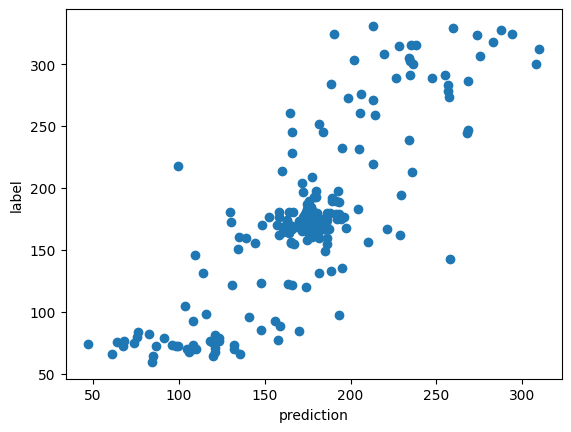

In [17]:
# Plot the predictions against the actual labels
plt.scatter(prediction,val_labels)
plt.xlabel('prediction')
plt.ylabel('label');